In [1]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import seaborn as sns
from collections import Counter, defaultdict


from torchtext import data
from torchtext import datasets

RANDOM_SEED = 2020
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [2]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [3]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
decode_map = ["NEGATIVE", "POSITIVE"]
def to_sentiment(sentiment):
  sentiment = int(sentiment)
  if sentiment == 4:
    return 1
  else:
    return 0

df.sentiment = df.sentiment.apply(lambda x: to_sentiment(x))

c:\users\astro\miniconda3\envs\bigdata\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'NEGATIVE'), Text(1, 0, 'POSITIVE')]

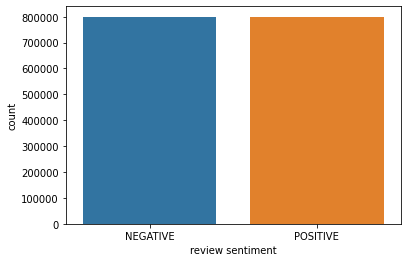

In [7]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(decode_map)

In [91]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths= True)
LABEL = data.LabelField(dtype=torch.float)

# Map data to fields
fields = [('label', LABEL), ('id',None),('date',None),('query',None),
      ('name',None), ('text', TEXT),('category',None)]

# Apply field definition to create torch dataset
dataset = data.TabularDataset(
        path="training.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

In [92]:
(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 1280000
Number of test data: 160000
Number of validation data: 160000


In [93]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

# Most frequent tokens
TEXT.vocab.freqs.most_common(10)

.vector_cache\glove.6B.zip: 862MB [07:35, 1.89MB/s]                                                                                                                                                                             
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:22<00:00, 17736.58it/s]


[('i', 798765),
 ('!', 722519),
 ('.', 647033),
 (' ', 469630),
 ('to', 452417),
 ('the', 417733),
 (',', 385991),
 ('a', 304663),
 ('my', 253099),
 ('it', 242828)]

In [104]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device = device)

In [114]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [115]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,210,257 trainable parameters


In [116]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

embedding.weight
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
fc.weight
fc.bias


In [117]:
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [118]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [119]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [120]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [121]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 8m 28s
	Train Loss: 0.433 | Train Acc: 79.72%
	 Val. Loss: 0.374 |  Val. Acc: 84.02%
Epoch: 02 | Epoch Time: 7m 58s
	Train Loss: 0.372 | Train Acc: 83.50%
	 Val. Loss: 0.357 |  Val. Acc: 84.78%


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()